In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, precision_recall_curve, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import RocCurveDisplay
from sklearn import set_config

import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
set_config("display")

In [34]:
from ucimlrepo import fetch_ucirepo 
htru2 = fetch_ucirepo(id=372)

X = htru2.data.features 
y = htru2.data.targets['class'].replace({0: False, 1: True})
y_df = htru2.data.targets.replace({0: False, 1: True})

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = htru2.data.targets['class'], random_state = 42)

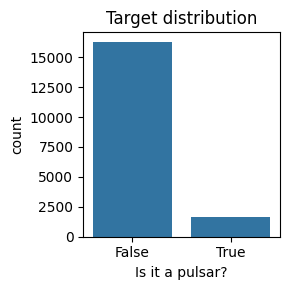

In [32]:
f, ax = plt.subplots(figsize=(3,3))
sns.countplot(data = y_df, x = 'class', ax=ax)
plt.title('Target distribution')

plt.xlabel('Is it a pulsar?')

plt.tight_layout()
plt.show()

In [36]:
baseline = y.value_counts(normalize=True)
print(baseline)

class
False    0.908426
True     0.091574
Name: proportion, dtype: float64


In [72]:
pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=1))
]).fit(x_train, y_train)

y_preds_1 = pipeline_1.predict(x_test)

print('1 neighbors')
print('accuracy', accuracy_score(y_preds_1, y_test))
print('precision', precision_score(y_preds_1, y_test))
print('recall', recall_score(y_preds_1, y_test))
print('f1', f1_score(y_preds_1, y_test))

1 neighbors
accuracy 0.9731843575418995
precision 0.8463414634146341
recall 0.8589108910891089
f1 0.8525798525798526


In [163]:
# ROC-AUC scoring
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(weights='distance', p = 1))
])

params = {
    'model__n_neighbors': np.arange(1, 201, 5),
}

grid = GridSearchCV(
    pipeline,
    param_grid = params,
    cv = 10,
    scoring = 'f1',
).fit(x_train, y_train)
print(grid.best_params_)

{'model__n_neighbors': 6}


In [195]:
# ROC-AUC scoring
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(weights='distance', p = 1))
])

params2 = {
    'model__n_neighbors': np.arange(1, 201, 5),
}

grid2 = GridSearchCV(
    pipeline2,
    param_grid = params2,
    cv = 10,
    scoring = 'recall',
).fit(x_train, y_train)
print(grid2.best_params_)

preds2 = grid2.predict(x_test)

print('accuracy', accuracy_score(preds2, y_test))
print('precision', precision_score(preds2, y_test))
print('recall', recall_score(preds2, y_test))
print('f1', f1_score(preds2, y_test))

{'model__n_neighbors': 1}
accuracy 0.9736312849162011
precision 0.8390243902439024
recall 0.8686868686868687
f1 0.8535980148883374


In [203]:
preds = grid.predict(x_test)

print('accuracy', accuracy_score(preds, y_test))
print('precision', precision_score(preds, y_test))
print('recall', recall_score(preds, y_test))
print('f1', f1_score(preds, y_test))

accuracy 0.9796648044692737
precision 0.8439024390243902
recall 0.9276139410187667
f1 0.8837803320561941


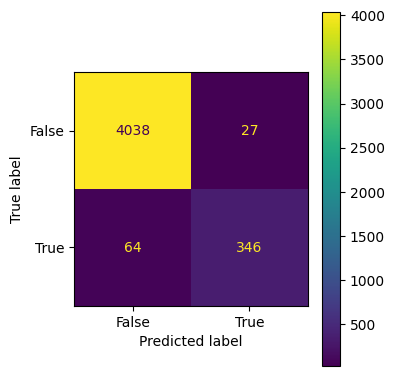

In [200]:
def get_confusion_matrix(threshold):
    y_pred_probas = grid.predict_proba(x_test)
    y_preds = np.where(y_pred_probas[:, 1] > threshold, True, False)
    return confusion_matrix(y_test, y_preds, labels = [False, True])

cm = get_confusion_matrix(0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False,True])

f, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

In [201]:
print(classification_report(grid.predict(x_test), y_test))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99      4102
        True       0.84      0.93      0.88       373

    accuracy                           0.98      4475
   macro avg       0.92      0.96      0.94      4475
weighted avg       0.98      0.98      0.98      4475



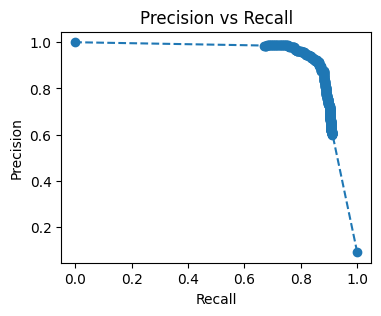

In [204]:
test_predictions = grid.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions[:, 1])

f, ax = plt.subplots(figsize=(4,3))
plt.plot(recall, precision, '--o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.show()

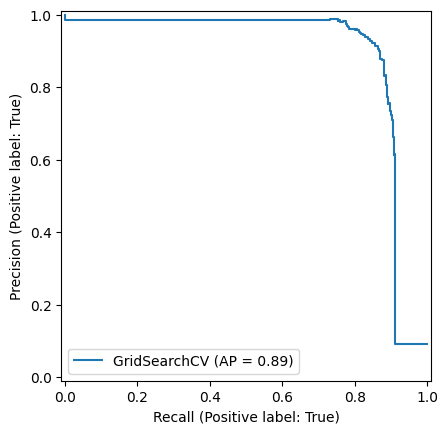

In [202]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    grid, x_test, y_test, pos_label = True,
)